# 5. Modelagem e Métricas de Performance

In [383]:
# Libs:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns',30)
import os 
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
import scipy
import scipy.stats

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, learning_curve
from sklearn.model_selection import cross_val_score

# Transformações:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Modelos de regressão
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

# Métricas
from sklearn.metrics import fbeta_score, log_loss

#Feature Importance
import shap

#Deploy do modelo
import pickle

import warnings
warnings.filterwarnings("ignore")

## Dados Constantes

In [237]:
DATA_INPUT = '../data/DATA_feature_selected_V2.csv'
DATA_TEST_INPUT = '../data/data_test_for_modeling.csv'
SEED = 123

In [102]:
df_train = pd.read_csv(DATA_INPUT)

In [103]:
df_train.head()

,Unnamed: 0,Mes,Número Banheiros,Número Camas,Número Comentários,Número Hóspedes,Taxa,Semana_do_ano,Jacuzzi,Academia,Secadora,Localização,Piscina,Permitido animais,Preço/Noite
0,0,3,1,3,18,4,60.0,9,0,0,0,0.029461,1,0,184.0
1,1,3,1,4,41,4,30.0,11,0,0,0,0.042766,1,0,198.0
2,2,3,2,8,7,10,0.0,9,0,0,0,0.003089,0,0,351.0
3,3,3,1,2,5,4,60.0,12,0,0,0,0.018769,0,1,191.0
4,4,2,1,4,3,4,58.0,8,0,0,0,0.018769,0,1,124.0


In [104]:
df_train = df_train.drop('Unnamed: 0', axis=1)

In [105]:
df_train.shape

(4209, 14)

In [106]:
df_train.dtypes

Mes                     int64
Número Banheiros        int64
Número Camas            int64
Número Comentários      int64
Número Hóspedes         int64
Taxa                  float64
Semana_do_ano           int64
Jacuzzi                 int64
Academia                int64
Secadora                int64
Localização           float64
Piscina                 int64
Permitido animais       int64
Preço/Noite           float64
dtype: object

In [107]:
X = df_train.drop('Preço/Noite', axis=1)
y = df_train['Preço/Noite']

In [108]:
coluns = X.columns.tolist()

## 5.1 Tabela Regressão Linear pelo Stats model - visão inicial

In [109]:
X = sm.add_constant(X)

In [110]:
# Descobrindo os betas
modelo_linear_multiplo = sm.OLS(y,X)
modelo_linear_multiplo = modelo_linear_multiplo.fit()

In [111]:
# Sumary
print(modelo_linear_multiplo.summary())

                            OLS Regression Results                            
Dep. Variable:            Preço/Noite   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.526
Method:                 Least Squares   F-statistic:                     360.9
Date:                Tue, 04 May 2021   Prob (F-statistic):               0.00
Time:                        16:47:40   Log-Likelihood:                -25411.
No. Observations:                4209   AIC:                         5.085e+04
Df Residuals:                    4195   BIC:                         5.094e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 79.0260      8

**Considerações do Sumário:**<br>
O Beta 0 é igual a: -79.0260 E o R2 do modelo reultou em 52,80% <br>
P-valor da Academia e Semana do Ano não são significante <br>
Durbin-Watson 1.98 - temos uma correlação positiva

In [112]:
predictions = modelo_linear_multiplo.predict(X)

In [113]:
# Erro médio Quadratico
mse = np.mean((y - predictions)**2)
print(f'MSE: {round(mse, 2)}')

MSE: 10268.33


In [114]:
# Erro Médio Absoluto
mae = np.mean(abs(y - predictions))
print(f'MAE: {round(mae, 2)}')

MAE: 71.51


In [115]:
# Porcentagem do Erro médio Absoluto
mape = 100*np.mean(abs(y - predictions)/ y)
print(f'MAPE: {round(mape, 2)}')

MAPE: 29.89


In [118]:
def summary_linear_regression(X, y):
    X = sm.add_constant(X)
    # Descobrindo os betas
    modelo_linear_multiplo = sm.OLS(y,X)
    modelo_linear_multiplo = modelo_linear_multiplo.fit()
    print(modelo_linear_multiplo.summary())

## 5.2 Teste de Normalidade

**QQ Plot**

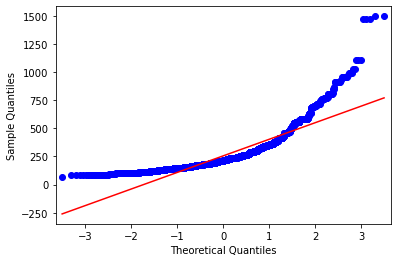

In [119]:
# qq plot
qqplot(y, line='s')
plt.show()

**Teste Shapiro Wilk**

In [120]:
def shapiro_test(df, alpha=0.05):
    """
    Shapiro Wilk test
    df = Dataframe
    alpha = indice of significancy. Default is 0.05
    """
    stat, p = scipy.stats.shapiro(df)
    print('p-valor: p=%.3f' % (p))
    # interpret
    alpha = alpha
    if p > alpha:
        print('A amostra parece ser normalmente distribuiída Gaussian. Não rejeitamos H0')
    else:
        print('A amostra NÃO parece ser normalmente distribuiída Gaussian. Rejeitamos H0')
    return stat, p

In [121]:
shapiro_test(df_train)

p-valor: p=0.000
A amostra NÃO parece ser normalmente distribuiída Gaussian. Rejeitamos H0


(0.3734293580055237, 0.0)

Verificamos que o Target não possui uma distruição Normal, neste caso vamos transforma-la

### Transformação para uma Normal

**Box Cos**

In [122]:
# transformando os dados

transformed_y, lambda_found = scipy.stats.boxcox(y)

In [123]:
print(f'Melhor lambda: {lambda_found}')

Melhor lambda: -0.4897796628352117


Agora vamos plotar o histograma dos nossos dados transformados!

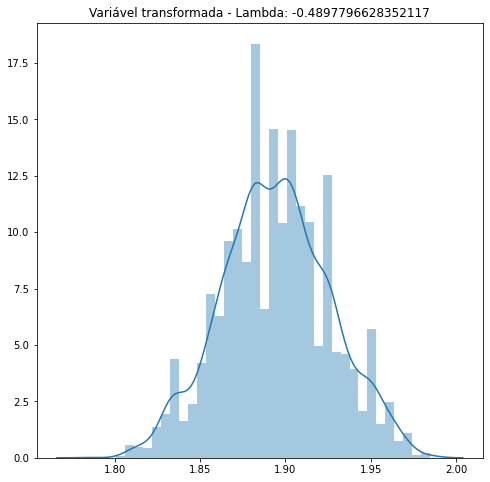

In [124]:
plt.figure(figsize = (8, 8))
sns.distplot(transformed_y)
plt.title(f'Variável transformada - Lambda: {lambda_found}')
plt.show()

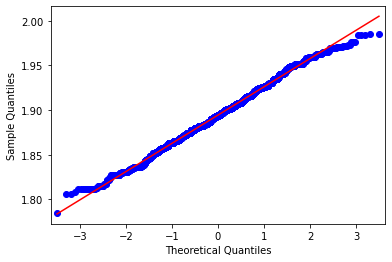

In [125]:
# qq plot
qqplot(transformed_y, line='s')
plt.show()

In [126]:
# Após realizar alguma previsão para essa variável, preciso aplicar a transformação inversa!

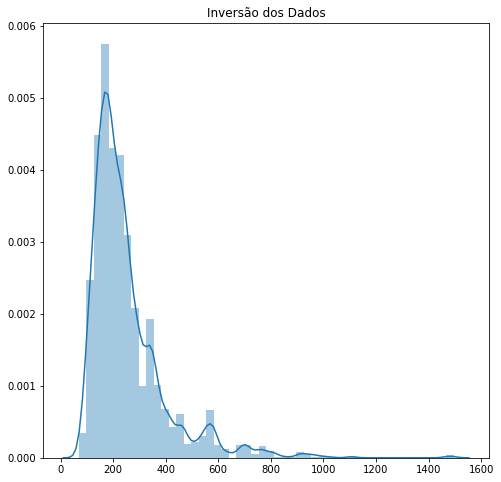

In [127]:
plt.figure(figsize=(8,8))
inverse_data = scipy.special.inv_boxcox(transformed_y, lambda_found)
sns.distplot(inverse_data)
plt.title('Inversão dos Dados')
plt.show()

In [128]:
print(f'Transformação inversa: {np.mean(((inverse_data - y)/y))*100}')

Transformação inversa: -9.47517641575783e-16


## 5.3 Data Prep

In [132]:
# Vamos utilizar o RobustScaler pois como ele trabalha com os quartis, neutraliza o efeito dos outli
pipe = Pipeline(steps=[('scaler', RobustScaler())])

In [133]:
X = pipe.fit_transform(X)

## 5.4 Divisão em treino e teste para avaliação dos modelos sem normalidade no Target

In [135]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=123)

## 5.4.1. Modelos de Regressão

In [136]:
def create_pipe(model, transformers_pipeline):
    """
    model = Model funccion
    Return a pipeline with model and transformations
    """
    pipe = Pipeline(steps=[('scaler', RobustScaler()),
                            ('model', model)])
    return pipe

In [137]:
def cv_scores(estimator, X, y, cv=5, scoring='neg_mean_absolute_error'):
    """
    Cros Validation 
    estimatior = create_pipe funccion with model and transformation
    X = X
    y = target
    scoring = score of model. Default is neg_mean_absolute_error for Regression Models
    cv = Default is 5 fold. Stratified K Fold is also possible.
    Print the score from train and test of modeling
    """
    cv_scores = cross_validate(estimator=estimator,
                                X = X,
                                y = y,
                                scoring =scoring,
                                cv = cv,
                                return_train_score=True)
    print(f'{scoring} no Treino: {np.mean(cv_scores["train_score"]):.4f}')
    print(f'{scoring} no Teste: {np.mean(cv_scores["test_score"]):.4f}')

Para avaliação dos modelos vamos utilizar Negativo do Erro médio Absoluto <br>
Quanto menor melhor, ou seja, mais próximo de zero melhor.<br>
Vamos os escolher os **três** melhores.

**Linear Regression**

In [138]:
pipe_LR = create_pipe(LinearRegression(), pipe)

In [139]:
cv_scores(pipe_LR, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -71.0321
neg_mean_absolute_error no Teste: -71.4406


**K Neighbors Regressor**

In [140]:
pipe_KNR = create_pipe(KNeighborsRegressor(n_neighbors=int(np.sqrt(len(df_train)))), pipe)

In [141]:
cv_scores(pipe_KNR, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -66.8071
neg_mean_absolute_error no Teste: -67.6080


**SVR**

In [142]:
pipe_SVR = create_pipe(SVR(), pipe)

In [143]:
cv_scores(pipe_SVR, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -78.4037
neg_mean_absolute_error no Teste: -78.7871


**Decision Tree**

In [144]:
pipe_Dtree = create_pipe(DecisionTreeRegressor(random_state=123, max_depth=5), pipe)

In [145]:
cv_scores(pipe_Dtree, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -62.2953
neg_mean_absolute_error no Teste: -65.1290


**Random Forest**

In [146]:
pipe_RF = create_pipe(RandomForestRegressor(random_state=123, max_depth=5), pipe)

In [147]:
cv_scores(pipe_RF, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -57.6956
neg_mean_absolute_error no Teste: -60.0071


**LGBM Regressor**

In [148]:
pipe_LGBM = create_pipe(LGBMRegressor(random_state=123), pipe)

In [149]:
cv_scores(pipe_LGBM, X_train, y_train, cv=skf, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -26.0926
neg_mean_absolute_error no Teste: -35.6300


LGBM é possivel perceber uma tendência para overfitting

## Top 3 modelos

* Random Forest <br>
* Decision Tree <br>
* K Neighbors Regressor <br>

# 5.5 Modelo de regressão com o Target normalizado pelo Box Cox

In [150]:
transformed_y

array([1.88297573, 1.88857655, 1.92602744, ..., 1.86626801, 1.83079755,
       1.92386877])

In [151]:
df_train_transformed = df_train.copy()

In [152]:
df_train_transformed['Preço/Noite_Normalizado'] = transformed_y

In [153]:
df_train_transformed

,Mes,Número Banheiros,Número Camas,Número Comentários,Número Hóspedes,Taxa,Semana_do_ano,Jacuzzi,Academia,Secadora,Localização,Piscina,Permitido animais,Preço/Noite,Preço/Noite_Normalizado
0,3,1,3,18,4,60.0,9,0,0,0,0.029461,1,0,184.0,1.882976
1,3,1,4,41,4,30.0,11,0,0,0,0.042766,1,0,198.0,1.888577
2,3,2,8,7,10,0.0,9,0,0,0,0.003089,0,0,351.0,1.926027
3,3,1,2,5,4,60.0,12,0,0,0,0.018769,0,1,191.0,1.885853
4,2,1,4,3,4,58.0,8,0,0,0,0.018769,0,1,124.0,1.849122
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4204,3,3,4,34,10,75.0,11,0,0,0,0.005940,1,0,581.0,1.951336
4205,3,1,3,16,4,49.5,9,0,0,0,0.003326,0,1,247.0,1.904297
4206,3,1,2,6,6,10.0,9,0,0,0,0.011879,0,1,150.0,1.866268
4207,3,1,6,38,6,10.0,11,0,0,0,0.009979,0,0,103.0,1.830798


In [154]:
df_train_transformed = df_train_transformed.drop('Preço/Noite', axis=1)
X_ = df_train_transformed.drop('Preço/Noite_Normalizado', axis=1)
y_ = df_train_transformed['Preço/Noite_Normalizado']

### 5.5.1. Data Prep

In [155]:
X_ = pipe.fit_transform(X_)

### 5.5.2. Divisão em treino e teste

In [156]:
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_,
                                                        y_,
                                                        test_size=0.2,
                                                        random_state=123)

In [157]:
X_train_.shape, X_test_.shape

((3367, 13), (842, 13))

## 5.5.3. Modelos de Regressão com o Target normalizado

**Linear Regression**

In [158]:
cv_scores(pipe_LR, X_train_, y_train_, cv = 5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0184
neg_mean_absolute_error no Teste: -0.0185


**K Nearest Neighbors Regressor**

In [159]:
cv_scores(pipe_KNR, X_train_, y_train_, cv = 5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0175
neg_mean_absolute_error no Teste: -0.0178


**SVR**

In [160]:
cv_scores(pipe_SVR, X_train_, y_train_, cv = 5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0262
neg_mean_absolute_error no Teste: -0.0262


**Decision Tree**

In [161]:
cv_scores(pipe_Dtree, X_train_, y_train_, cv = 5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0161
neg_mean_absolute_error no Teste: -0.0167


**Random Forest**

In [162]:
cv_scores(pipe_RF, X_train_, y_train_, cv = 5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0152
neg_mean_absolute_error no Teste: -0.0159


**LGBM Regressor**

In [163]:
cv_scores(pipe_LGBM, X_train_, y_train_, cv=5, scoring='neg_mean_absolute_error')

neg_mean_absolute_error no Treino: -0.0066
neg_mean_absolute_error no Teste: -0.0093


### Top 3 modelos com target normalizado

In [164]:
# Modelos que tiveram os menores erros são aquela que estão próximos a 0.

neg_mae_test = [0,-0.0186, -0.0179, -0.0262, -0.0167, -0.0159]
print(sorted(neg_mae_test))

[-0.0262, -0.0186, -0.0179, -0.0167, -0.0159, 0]


* Random Forest <br>
* Decision Tree <br>
* K Nearest Neighbors Regressor <br>

## 5.6. Escolha dos Hiperparâmetros - Target Normalizado

### K Nearest Neighbors Regressor

In [165]:
param_grid_KNR = {
                    'model__n_neighbors' : range(1, 100),
                    'model__weights' : ['uniform', 'distance'],
                    'model__p': range(1,11),
                    'model__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']
                    }

In [166]:
random_search_KNR = RandomizedSearchCV(estimator=pipe_KNR,
                                        param_distributions=param_grid_KNR,
                                        scoring='neg_mean_absolute_error',
                                        random_state=123,
                                        cv=5,
                                        n_iter=1000,
                                        n_jobs=-1,
                                        verbose=1)

In [167]:
random_search_KNR.fit(X_train_, y_train_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 1202 tasks      | elapsed:   20.8s
[Parallel(n_jobs=-1)]: Done 2512 tasks      | elapsed:   36.1s
[Parallel(n_jobs=-1)]: Done 4248 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 5000 out of 5000 | elapsed:  1.2min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              KNeighborsRegressor(n_neighbors=64))]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'model__metric': ['euclidean',
                                                          'manhattan',
                                                          'chebyshev',
                                                          'minkowski',
                                                          'wminkowski',
                                                          'seuclidean',
                                                          'mahalanobis'],
                                        'model__n_neighbors': range(1, 100),
                                        'model__p': range(1, 11),
                                        'model__weights': ['uniform',
   

In [168]:
print(f'Melhor Score do KNRegression: {-random_search_KNR.best_score_:.4f}')

Melhor Score do KNRegression: 0.0059


In [169]:
best_KNR = random_search_KNR.best_estimator_
y_pred_KNR = best_KNR.predict(X_test_)
print(f'Mean Absolute Error KNRegression no Teste {np.mean(abs(y_test_ - y_pred_KNR)):.4f}')

Mean Absolute Error KNRegression no Teste 0.0051


In [170]:
random_search_KNR.best_params_

{'model__weights': 'uniform',
 'model__p': 5,
 'model__n_neighbors': 1,
 'model__metric': 'manhattan'}

**Houve overfitting no KNN Regression, pois resultou em k = 1**

### Decision Tree

In [171]:
param_grid_Dtree = {
                'model__criterion' : ['mae'],
                'model__max_depth' : range(1, 11),
                'model__min_samples_split' : range(2, 41, 5),
                'model__min_samples_leaf' : range(2, 21, 2),
                }

In [172]:
random_search_Dtree = RandomizedSearchCV(estimator=pipe_Dtree,
                                        param_distributions=param_grid_Dtree,
                                        scoring='neg_mean_absolute_error',
                                        random_state=123,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=1,
                                        n_iter=1000)

In [173]:
random_search_Dtree.fit(X_train_, y_train_)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 852 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2452 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 3016 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 3666 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  3.6min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              DecisionTreeRegressor(max_depth=5,
                                                                    random_state=123))]),
                   n_iter=1000, n_jobs=-1,
                   param_distributions={'model__criterion': ['mae'],
                                        'model__max_depth': range(1, 11),
                                        'model__min_samples_leaf': range(2, 21, 2),
                                        'model__min_samples_split': range(2, 41, 5)},
                   random_state=123, scoring='neg_mean_absolute_error',
                   verbose=1)

In [174]:
print(f'Melhor Score do Decision Tree Regression: {-random_search_Dtree.best_score_:.4f}')

Melhor Score do Decision Tree Regression: 0.0114


In [175]:
best_Dtree = random_search_Dtree.best_estimator_
y_pred_Dtree = best_Dtree.predict(X_test_)
print(f'Mean Absolute Error Decision Tree Regression no Teste {np.mean(abs(y_test_ - y_pred_Dtree)):.4f}')

Mean Absolute Error Decision Tree Regression no Teste 0.0113


In [176]:
random_search_Dtree.best_params_

{'model__min_samples_split': 2,
 'model__min_samples_leaf': 2,
 'model__max_depth': 10,
 'model__criterion': 'mae'}

In [195]:
best_Dtree

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=10,
                                       min_samples_leaf=2, random_state=123))])

### Random Forest

In [177]:
param_grid_RF = {
                'model__n_estimators': [10, 25, 50, 75, 100, 150],
                'model__criterion' : ['mae'],
                'model__max_depth' : range(1, 11),
                'model__min_samples_split' : range(2, 41, 5),
                'model__min_samples_leaf' : range(2, 21, 2),
                'model__max_features': ['auto', 'sqrt', 'log2'],
                }

In [178]:
random_search_RF = RandomizedSearchCV(estimator=pipe_RF,
                                        param_distributions=param_grid_RF,
                                        scoring='neg_mean_absolute_error',
                                        random_state=123,
                                        cv=5,
                                        n_jobs=-1,
                                        verbose=1,
                                        n_iter=250)

In [179]:
random_search_RF.fit(X_train_, y_train_)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed: 19.4min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                             ('model',
                                              RandomForestRegressor(max_depth=5,
                                                                    random_state=123))]),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'model__criterion': ['mae'],
                                        'model__max_depth': range(1, 11),
                                        'model__max_features': ['auto', 'sqrt',
                                                                'log2'],
                                        'model__min_samples_leaf': range(2, 21, 2),
                                        'model__min_samples_split': range(2, 41, 5),
                                        'model__n_estimators': [10, 25, 50, 75,
                                                                100, 150]},
             

In [180]:
print(f'Melhor Score do Random Forest Regression: {-random_search_RF.best_score_:.4f}')

Melhor Score do Random Forest Regression: 0.0107


In [181]:
best_RF = random_search_RF.best_estimator_
y_pred_RF = best_RF.predict(X_test_)
print(f'Mean Absolute Error Random Forest Regression no Teste {np.mean(abs(y_test_ - y_pred_RF)):.4f}')

Mean Absolute Error Random Forest Regression no Teste 0.0099


In [182]:
random_search_RF.best_params_

{'model__n_estimators': 100,
 'model__min_samples_split': 7,
 'model__min_samples_leaf': 2,
 'model__max_features': 'auto',
 'model__max_depth': 10,
 'model__criterion': 'mae'}

In [352]:
train_sizes= np.linspace(0.5, 1, 5)
train_sizes, train_scores, test_scores, fit_times, _ = \
    learning_curve(estimator=best_RF, 
                   X=X_train_, 
                   y=y_train_, 
                   cv=5, 
                   scoring='mean_absolute_error',
                   n_jobs=-1,
                   train_sizes=train_sizes,
                   return_times=True)
    
train_scores_mean = -np.mean(train_scores, axis=1)
train_scores_std = -np.std(train_scores, axis=1)
test_scores_mean = -np.mean(test_scores, axis=1)
test_scores_std = -np.std(test_scores, axis=1)
fit_times_mean = -np.mean(fit_times, axis=1)
fit_times_std = -np.std(fit_times, axis=1)

fig = plt.figure(figsize=(20, 5))

plt.title(f'Learning Curve')
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()
#plt.ylim((0,1))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
plt.legend(loc="best")
plt.show()

TypeError: learning_curve() got an unexpected keyword argument 'estimator'

# 5.7 Modelagem

### Decision Tree

In [193]:
best_Dtree.fit(X_train_, y_train_)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 DecisionTreeRegressor(criterion='mae', max_depth=10,
                                       min_samples_leaf=2, random_state=123))])

In [196]:
result_Dtree = best_Dtree.predict(X_test_)

In [197]:
len(result_Dtree)

842

In [198]:
# reconversão da variável
diaria = scipy.special.inv_boxcox(result_Dtree, lambda_found)

In [199]:
np.round(diaria,2)

array([ 177.  ,  150.  ,  177.  ,  219.46,  187.  ,  353.  ,  334.99,
        218.  ,  251.  ,  165.  ,  180.  ,  250.  ,  158.  ,  166.  ,
        180.  ,  559.  ,  145.  ,  232.  ,  193.  ,  226.  ,  180.  ,
        180.  ,  206.  ,  158.  ,  218.  ,  206.  ,  211.  ,  218.  ,
        144.34,  629.  ,  353.  ,  250.  ,  180.  ,  180.  ,  298.  ,
        219.46,  166.  ,  123.  ,  187.  ,  263.  ,  247.  ,  226.  ,
        158.  ,  118.  ,  250.  ,  425.  ,  218.  ,  145.  ,   89.  ,
        187.  ,  118.  ,  457.  ,  237.  ,   99.  ,  226.  ,  158.  ,
        807.  ,  149.  ,  240.  ,  250.  ,  177.  ,  145.  ,  180.  ,
        250.  ,  182.  ,  145.  ,  292.  ,  177.  ,  218.  ,  237.  ,
        344.  ,  218.  ,  219.46,  218.  ,  144.34,  180.  ,  158.  ,
        482.75,  263.  ,  427.  ,  293.  ,  182.98,  760.  ,  182.  ,
         94.  ,  207.  ,  194.  ,  206.  ,  218.  ,  158.  ,  218.  ,
        180.  ,  193.  ,  187.  ,  460.48,  206.  ,  124.  ,  180.  ,
        197.23,  344

### Random Forest

In [200]:
best_RF.fit(X_train_, y_train_)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 RandomForestRegressor(criterion='mae', max_depth=10,
                                       min_samples_leaf=2, min_samples_split=7,
                                       random_state=123))])

In [201]:
result_RF = best_RF.predict(X_test_)

In [202]:
diaria_RF = scipy.special.inv_boxcox(result_RF, lambda_found)

In [203]:
np.round(diaria_RF, 2)

array([182.99, 156.62, 186.74, 233.1 , 210.69, 318.06, 324.34, 204.67,
       221.8 , 162.33, 183.75, 248.75, 176.51, 160.72, 173.05, 576.65,
       144.09, 217.85, 191.  , 194.84, 169.71, 175.54, 195.89, 185.37,
       231.16, 216.73, 185.06, 202.39, 190.41, 465.21, 320.84, 241.34,
       183.75, 177.84, 292.37, 198.93, 185.1 , 123.24, 254.43, 240.5 ,
       192.33, 241.96, 148.41, 122.22, 247.82, 236.52, 184.32, 143.38,
       118.95, 224.15, 122.12, 445.21, 223.99, 100.94, 223.72, 156.93,
       808.08, 184.67, 222.42, 248.75, 220.28, 148.16, 167.98, 204.48,
       172.84, 148.26, 312.57, 180.62, 266.34, 238.33, 328.91, 207.27,
       201.71, 275.27, 127.93, 163.35, 157.91, 421.06, 263.31, 348.45,
       291.37, 176.75, 597.33, 190.48, 124.58, 231.59, 191.22, 208.58,
       226.79, 148.26, 214.25, 165.92, 201.28, 185.52, 498.97, 158.35,
       135.22, 191.96, 175.47, 348.42, 127.86, 226.02, 118.47, 168.5 ,
       278.29, 354.8 , 166.4 , 247.44, 211.08, 100.28, 177.81, 174.97,
      

In [204]:
len(np.round(diaria_RF, 2))

842

## 5.8. Comparação entre os modelos Decision Tree e Random Forest

In [205]:
def error_metrics(predict_results, name='Name of model'):
    mse = np.mean((y_test_ - predict_results)**2)
    mae = np.mean(abs(y_test_ - predict_results))
    mape = 100*np.mean(abs(y_test_ - predict_results)/ y_test_)
    print(f'Errors: {name}')
    print(f'MSE: {round(mse, 4)}')
    print(f'MAE: {round(mae, 4)}')
    print(f'MAPE: {round(mape, 4)}')

In [206]:
error_metrics(result_Dtree, name='Decision Tree')

Errors: Decision Tree
MSE: 0.0003
MAE: 0.0113
MAPE: 0.5981


In [207]:
error_metrics(result_RF, name='Random Forest')

Errors: Random Forest
MSE: 0.0002
MAE: 0.0099
MAPE: 0.5237


### Random Forest obteve o menor erro

# 5.9 Modelagem com Dados de Teste utilizando Random Forest Regressor

In [286]:
df_test = pd.read_csv(DATA_TEST_INPUT)

In [295]:
df_test.shape

(1053, 14)

In [287]:
df_test.head()

,Unnamed: 0,Mes,Número Banheiros,Número Camas,Número Comentários,Número Hóspedes,Taxa,Semana_do_ano,Jacuzzi,Academia,Secadora,Localização,Piscina,Permitido animais,Preço/Noite
0,0,2,3,8,3,16,100.0,7,0,0,0,0.007597,1,0,870.0
1,1,3,2,9,7,12,50.0,9,0,0,1,0.013295,1,0,338.0
2,2,4,1,2,14,4,50.0,14,0,0,0,0.025641,0,0,127.0
3,3,4,2,3,4,6,0.0,13,0,0,0,0.014245,0,0,169.0
4,4,4,1,2,8,4,60.0,15,0,0,0,0.010446,0,0,111.0


In [288]:
df_test = df_test.drop('Unnamed: 0', axis=1)

In [254]:
X__test = df_test.drop('Preço/Noite', axis=1)
y__test = df_test['Preço/Noite']

In [255]:
# transformação do y de teste
transformed_y_test, lambda_found_test = scipy.stats.boxcox(y__test)

### Melhor modelo - Random Forest

**Fit nos dados de treino**

In [289]:
best_RF.fit(X_, y_)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 RandomForestRegressor(criterion='mae', max_depth=10,
                                       min_samples_leaf=2, min_samples_split=7,
                                       random_state=123))])

**Predict nos dados de Test**

In [290]:
previsao = best_RF.predict(X__test)

**Transformação Inversa da previsão**

In [291]:
previsao_preco_noite = scipy.special.inv_boxcox(previsao, lambda_found)

In [292]:
np.round(previsao_preco_noite, 2)

array([654.37, 283.97, 184.39, ..., 580.43, 213.96, 208.9 ])

In [294]:
len(previsao)

1053

# 5.10. Avaliação de Performance

In [297]:
# Erro médio Quadratico
mse = np.mean((y__test - previsao_preco_noite)**2)
print(f'MSE: {round(mse, 2)}')

MSE: 6474.15


In [298]:
# Erro Médio Absoluto
mae = np.mean(abs(y__test - previsao_preco_noite))
print(f'MAE: {round(mae, 2)}')

MAE: 50.45


In [299]:
# Porcentagem do Erro médio Absoluto
mape = 100*np.mean(abs(y__test - previsao_preco_noite)/ y__test)
print(f'MAPE: {round(mape, 2)}')

MAPE: 19.13


# Exportando o modelo usando o Pickle

In [391]:
MODEL_OUTPUT_PATH = '../models'
MODEL_OUPUT_NAME = 'model_v0.pkl'

In [385]:
pickle.dump(best_RF, open(os.path.join(MODEL_OUTPUT_PATH, MODEL_OUPUT_NAME ), 'wb'))

# 6. Feature Importance

## 6.1. SHAP feature importance

Vamos utilizar a biblioteca Shap para esta análise

In [333]:
X_importance = df_train.drop('Preço/Noite', axis=1)

In [334]:
explainer = shap.Explainer(best_RF.predict, X_importance)

In [335]:
explainer

In [336]:
shap_values = explainer(X_importance)

Permutation explainer: 4210it [09:06,  7.70it/s]                                                                       


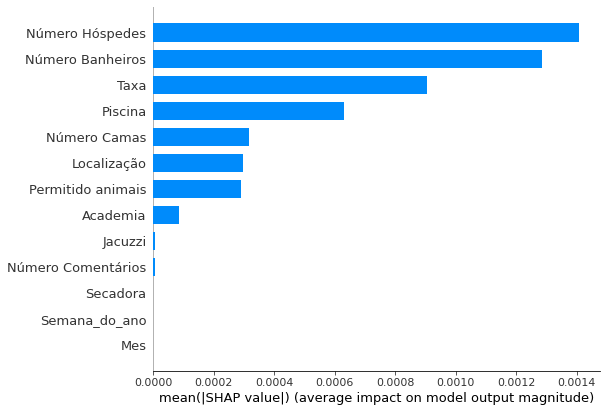

In [339]:
shap.summary_plot(shap_values, X_importance, plot_type="bar")

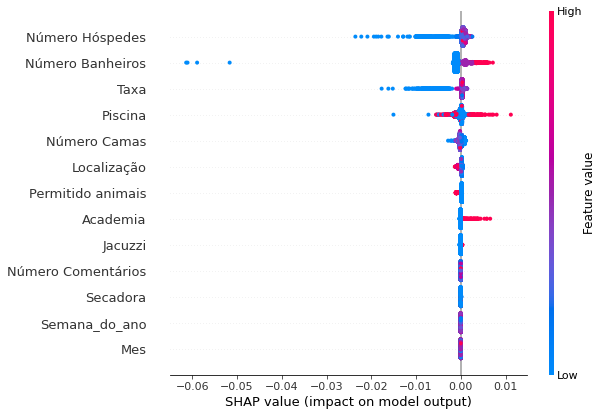

In [340]:
shap.summary_plot(shap_values, X_importance)

As features que mais explicam o modelo são: Número de hóspedes e número de banheiros seguindo essa ordem de importência. <br>
E as que menos explicam são os meses e semana do ano, ou seja, o período da estadia.<br>
Isso nos lea a concluir a capacidade do imóvel afeta muito mais do que a data seleciodada para o preço por noite!